In [6]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
from scipy.stats import gmean, hmean
from tqdm import tqdm
from skdim.id import TLE
import torch

from scipy.spatial.distance import cdist
from transformers import RobertaTokenizer
from transformers import RobertaModel

In [7]:
np.random.seed(42)
random.seed(42)

## Loading data

In [23]:
df = pd.read_csv("chatgpt_filtered.csv")
# df = pd.read_csv("roft_duplicates_removed.csv")
df.head()

,Unnamed: 0,prompt_body,gen_body,label,dataset,model
0,0,HOW TO MAKE: Baby Shell Pasta Salad With Kalam...,"In a large roasting pan, combine the fennel bu...",2,Recipes,gpt-3.5-turbo
1,1,HOW TO MAKE: Nest Cookies Ingredients: 1 12 cu...,"To make the white chocolate filling, heat the ...",8,Recipes,gpt-3.5-turbo
2,2,HOW TO MAKE: Pink Lemonade Cupcakes Ingredient...,"In a separate bowl, mix together sugar and veg...",7,Recipes,gpt-3.5-turbo
3,3,HOW TO MAKE: Beef Stroganaff Ingredients: 1 12...,Add 2 cups of water and the beefy mushroom dry...,7,Recipes,gpt-3.5-turbo
4,4,HOW TO MAKE: One-Pan Creamy Chicken and Veggie...,Add chicken pieces to the bag and shake to coa...,2,Recipes,gpt-3.5-turbo


In [24]:
nlls_file = open('./ss_nlls-full.txt', 'r')
lines = []
for line in nlls_file.readlines():
    lines.append(line.strip())
nlls_file.close()

In [25]:
len(df), len(lines)

(6940, 6940)

In [26]:
# convert from string to floats
nlls = []
for x in lines:
    x = x[2:-2].split('], [')
    nlls_curr = []
    for y in x:
        y = y.split(', ')
        y = [float(z) for z in y]
        nlls_curr.append(y)
    nlls.append(nlls_curr)

In [27]:
# calculate mean and std for sentences
means = []
stds = []

for nll in nlls:
    curr_mean = []
    curr_std = []
    for x in nll:
        curr_mean.append(np.mean(x))
        curr_std.append(np.std(x))
    means.append(curr_mean)
    stds.append(curr_std)

In [28]:
df['nlls'] = nlls
df['nlls_means'] = means
df['nlls_stds'] = stds

In [29]:
df.head()

,Unnamed: 0,prompt_body,gen_body,label,dataset,model,nlls,nlls_means,nlls_stds
0,0,HOW TO MAKE: Baby Shell Pasta Salad With Kalam...,"In a large roasting pan, combine the fennel bu...",2,Recipes,gpt-3.5-turbo,"[[9.778079986572266, 5.296655654907227, 1.8474...","[2.2431791598137996, 2.290042637919004, 1.2165...","[1.78121487211916, 2.396818007539273, 1.041623..."
1,1,HOW TO MAKE: Nest Cookies Ingredients: 1 12 cu...,"To make the white chocolate filling, heat the ...",8,Recipes,gpt-3.5-turbo,"[[9.778079986572266, 5.296655654907227, 1.8474...","[1.9654368431171558, 1.0922505952741788, 1.233...","[1.9288029551473864, 1.9932147896309338, 1.226..."
2,2,HOW TO MAKE: Pink Lemonade Cupcakes Ingredient...,"In a separate bowl, mix together sugar and veg...",7,Recipes,gpt-3.5-turbo,"[[9.778079986572266, 5.296655654907227, 1.8474...","[1.457881400914044, 3.1261325538158418, 2.7490...","[1.6026464269458491, 4.201056198453176, 2.2851..."
3,3,HOW TO MAKE: Beef Stroganaff Ingredients: 1 12...,Add 2 cups of water and the beefy mushroom dry...,7,Recipes,gpt-3.5-turbo,"[[9.778079986572266, 5.296655654907227, 1.8474...","[2.5014483901457143, 2.199417778290808, 3.0046...","[2.2487124066910247, 2.4536248801273284, 1.718..."
4,4,HOW TO MAKE: One-Pan Creamy Chicken and Veggie...,Add chicken pieces to the bag and shake to coa...,2,Recipes,gpt-3.5-turbo,"[[9.778079986572266, 5.296655654907227, 1.8474...","[2.231935001737796, 3.336339983073148, 1.92860...","[1.7310377283235172, 2.9357445541911824, 2.010..."


In [30]:
# save updated csv
# df.to_csv('chatgpt_filtered-nlls.csv', index=None)

In [31]:
np.unique(df['dataset'], return_counts=True)

(array(['New York Times', 'Presidential Speeches', 'Recipes',
        'Short Stories'], dtype=object),
 array([1313,  102, 3666, 1859]))

In [32]:
# in the case of chatgpt_filtered

# in-domain part of data
data_ind = df[df['dataset'].isin(['Presidential Speeches', "Short Stories", 'Recipes'])]
data_ind = data_ind.reset_index()
# out-of-domain part of data
data_ood = df[df['dataset'] == "New York Times"]
data_ood = data_ood.reset_index()


# in the case of roft_duplicated_removed

# # in-domain part of data
# data_ind = df[df['model'].isin(["baseline", 'ctrl-Politics', 'ctrl-nocode', 'davinci', 'finetuned'
#         , 'gpt2', 'human'])]
# data_ind = data_ind.reset_index()
# # out-of-domain part of data
# data_ood = df[df['model'] == 'gpt2-xl']
# data_ood = data_ood.reset_index()

In [33]:
# divide in-domain data into train, val and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_ind.drop(columns=['label']), 
                                                    data_ind['label'], 
                                                    test_size=0.2, 
                                                    random_state=42
                                                    )
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=42
                                                  )

In [34]:
X_ood = data_ood.drop(columns=['label'])
y_ood = data_ood['label']

In [35]:
len(X_train), len(X_val), len(X_test)

(3375, 1126, 1126)

In [36]:
train_nlls = [x + y for x, y in zip(np.array(X_train['nlls_means']), np.array(X_train['nlls_stds']))]
val_nlls = [x + y for x, y in zip(np.array(X_val['nlls_means']), np.array(X_val['nlls_stds']))]
test_nlls = [x + y for x, y in zip(np.array(X_test['nlls_means']), np.array(X_test['nlls_stds']))]
ood_nlls = [x + y for x, y in zip(np.array(data_ood['nlls_means']), np.array(data_ood['nlls_stds']))]

## Cleaning samples with nan

In [37]:
def clean_nlls(X, y):

    clean_nlls = []
    clean_labels = []

    for nlls, label in zip(X, y):
        if len(nlls) < 20:
            continue
        if 'nan' in str(nlls):
            continue
        else:
            clean_nlls.append(nlls)
            clean_labels.append(label)
            
    return clean_nlls, clean_labels

In [38]:
clean_train_nlls, clean_train_labels = clean_nlls(train_nlls, y_train)
clean_val_nlls, clean_val_labels = clean_nlls(val_nlls, y_val)
clean_test_nlls, clean_test_labels = clean_nlls(test_nlls, y_test)
clean_ood_nlls, clean_ood_labels = clean_nlls(ood_nlls, y_ood)

In [39]:
len(clean_train_nlls), len(clean_val_nlls), len(clean_test_nlls), len(clean_ood_nlls)

(3352, 1124, 1120, 1304)

## Training and testing a model

In [40]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, confusion_matrix

In [42]:
# choosing hyperparameters for GradientBoosting models
val_scores = {}

for max_depth in [3, 5, 7, 9]:
    for n_estimators in [10, 50, 100]:
        print(max_depth, n_estimators)
        gb_reg = GradientBoostingRegressor(max_depth=max_depth, n_estimators=n_estimators)
        gb_clf = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators)
        
        gb_reg.fit(np.array(clean_train_nlls), clean_train_labels)
        gb_clf.fit(np.array(clean_train_nlls), clean_train_labels)
        
        y_pred_reg = gb_reg.predict(np.array(clean_val_nlls))
        y_pred_clf = gb_clf.predict(np.array(clean_val_nlls))
        
        mse_reg = mean_squared_error(y_pred_reg, clean_val_labels)
        acc_clf = accuracy_score(y_pred_clf, clean_val_labels)
        
        val_scores[(max_depth, n_estimators)] = (mse_reg, acc_clf)
        print(mse_reg, acc_clf)

3 10
6.163170342682451 0.37277580071174377
3 50
4.463238166065415 0.44217081850533807
3 100
4.312078840586489 0.4501779359430605
5 10
5.345483470823402 0.42526690391459077
5 50
4.181126040232483 0.44395017793594305
5 100
4.094174474420218 0.44661921708185054
7 10
5.039253316130508 0.41725978647686834
7 50
4.133915207374751 0.4377224199288256
7 100
4.104773893066032 0.447508896797153
9 10
4.953903777594799 0.39412811387900354
9 50
4.273352488107875 0.4395017793594306
9 100
4.29179259767215 0.44395017793594305


In [47]:
# best parameters for reg
best_params_reg, best_results_reg = sorted(val_scores.items(), key=lambda x: x[1][0])[0]
best_params_reg, best_results_reg

((5, 100), (4.094174474420218, 0.44661921708185054))

In [48]:
# best parameters for clf
best_params_clf, best_results_clf = sorted(val_scores.items(), key=lambda x: x[1][0], reverse=True)[1]
best_params_clf, best_results_clf

((5, 10), (5.345483470823402, 0.42526690391459077))

In [56]:
# define soft accuracy metric
def soft_accuracy(y_pred, y_true):
    acc = 0
    
    for x, y in zip(y_true, y_pred):
        if y in [x-1, x, x+1]:
            acc += 1
            
    return acc / len(y_true)

In [51]:
# fitting models with best parameters in train data
gb_reg = GradientBoostingRegressor(max_depth=best_params_reg[0], n_estimators=best_params_reg[1])
gb_reg.fit(np.array(clean_train_nlls), clean_train_labels)

gb_clf = GradientBoostingClassifier(max_depth=best_params_clf[0], n_estimators=best_params_clf[1])
gb_clf.fit(np.array(clean_train_nlls), clean_train_labels)

In [53]:
# get predictions on test data
y_pred_reg = gb_reg.predict(np.array(clean_test_nlls))
y_pred_clf = gb_clf.predict(np.array(clean_test_nlls))

In [58]:
# metrics for GB Regressor on test data
mean_squared_error(y_pred_reg, clean_test_labels), \
accuracy_score(np.round(y_pred_reg), clean_test_labels), \
soft_accuracy(np.round(y_pred_reg), clean_test_labels)

(3.6762001546376903, 0.24910714285714286, 0.6214285714285714)

In [57]:
# metrics for GB Classifier on test data
accuracy_score(y_pred_clf, clean_test_labels), \
mean_squared_error(y_pred_clf, clean_test_labels), \
soft_accuracy(y_pred_clf, clean_test_labels)

(0.4714285714285714, 6.113392857142857, 0.6544642857142857)

In [59]:
# get predictions on ood data
ood_pred_reg = gb_reg.predict(np.array(clean_ood_nlls))
ood_pred_clf = gb_clf.predict(np.array(clean_ood_nlls))

In [60]:
# metrics for GB Regressor on ood data
mean_squared_error(ood_pred_reg, clean_ood_labels), \
accuracy_score(np.round(ood_pred_reg), clean_ood_labels)

(4.513315716930185, 0.22469325153374234)

In [61]:
# metrics for GB Classifier on ood data
accuracy_score(ood_pred_clf, clean_ood_labels), \
mean_squared_error(ood_pred_clf, clean_ood_labels)

(0.3458588957055215, 8.172546012269938)

In [81]:
# fitting Logistic Regression
lr = LogisticRegression()
lr.fit(np.array(clean_train_nlls), clean_train_labels)

LogisticRegression()

In [82]:
# getting predictions on test data
y_pred_lr = lr.predict(np.array(clean_test_nlls))

# metrics of LR for test data
accuracy_score(y_pred_lr, clean_test_labels), \
mean_squared_error(y_pred_lr, clean_test_labels), \
soft_accuracy(np.round(y_pred_lr), clean_test_labels)

(0.3669642857142857, 6.7160714285714285, 0.6151785714285715)

In [83]:
# getting predictions on ood data
ood_pred_lr = lr.predict(clean_ood_nlls)

# metrics of LR for ood data
accuracy_score(ood_pred_lr, clean_ood_labels), \
mean_squared_error(ood_pred_lr, clean_ood_labels), \
soft_accuracy(ood_pred_lr, clean_ood_labels)

(0.2446319018404908, 11.850460122699387, 0.46702453987730064)

Visualizing LR coefficients

<AxesSubplot:>

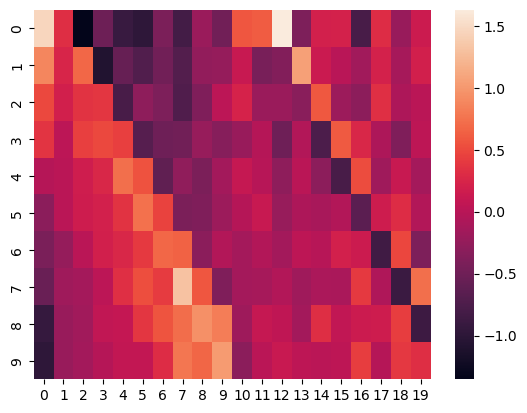

In [88]:
from seaborn import heatmap

heatmap(lr.coef_,  fmt=".1f")

Visualizing neg log likelihoods dynamics through sentences for each label:

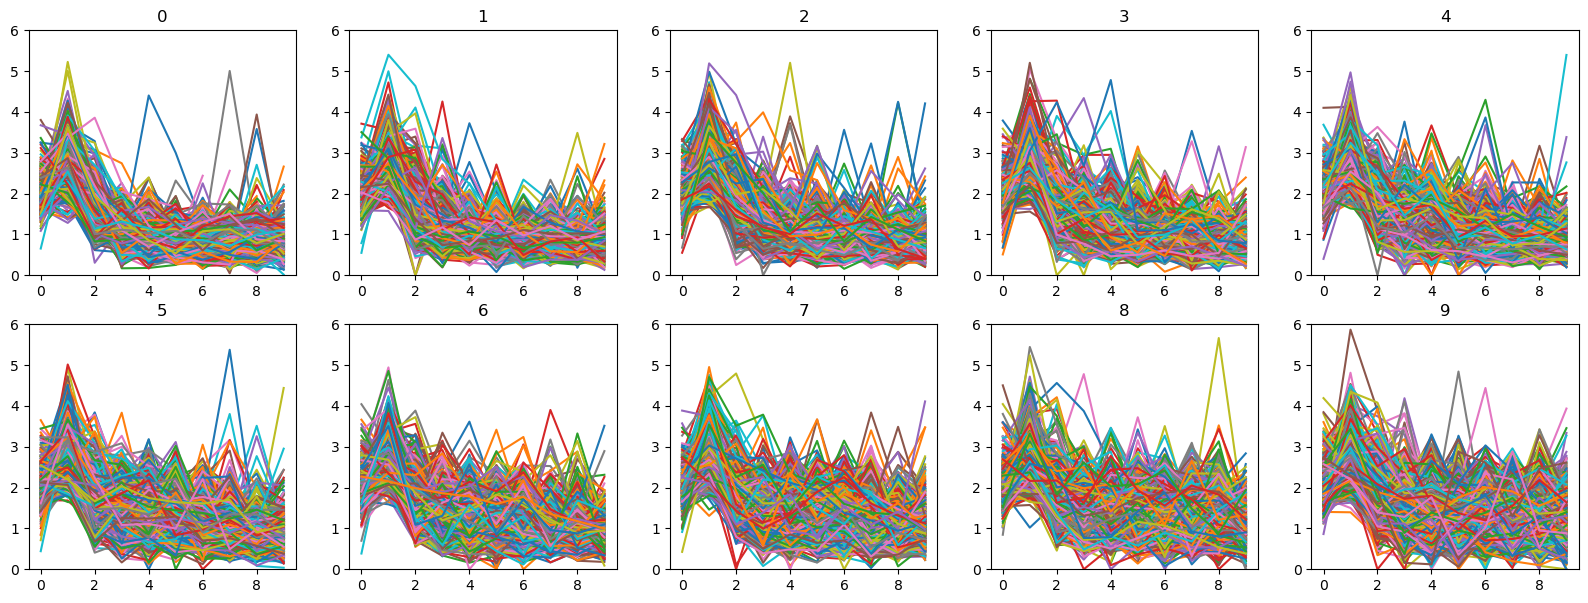

In [87]:
_, axes = plt.subplots(2, 5, figsize=(20, 7))

for label in range(10):

    df_label = df[(df['label']==label)]

    nlls_label = df_label['nlls_stds']

    for x in nlls_label:
        axes[label//5][label%5].plot(x)
    axes[label//5][label%5].set_title(label)
    axes[label//5][label%5].set_ylim(0, 6)
#     plt.show()